<a href="https://colab.research.google.com/github/holocenecap/holocene-colab/blob/main/Lemma_perp_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import requests
import pandas as pd

In [ ]:
# Helper Functions
def create_options(query, skip_iterator):
    return query.replace('skip_param', str(skip_iterator))


def get_funding_rates():
    trades = []
    query = '{"query":"{\\n fundingRateUpdatedEvents(first: 1000, orderBy: timestamp, orderDirection: desc, where : {timestamp_lt : \\"skip_param\\", amm : \\"0x8d22F1a9dCe724D8c1B4c688D75f17A2fE2D32df\\"}) {\\n id\\n amm\\n rate\\n underlyingPrice\\n timestamp\\n }\\n}\\n","variables":null}'

    
    headers = {
        'authority': 'api.thegraph.com',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="90", "Google Chrome";v="90"',
        'sec-ch-ua-mobile': '?0',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36',
        'content-type': 'application/json',
        'accept': '*/*',
        'origin': 'https://thegraph.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://thegraph.com/',
        'accept-language': 'en-US,en;q=0.9',
    }
    # Getting current time 
    timestamp = int(datetime.datetime.now().timestamp())
    # 1609459200 == Jan 1 00:00:00 GMT
    # Running till timestamp reaches the above time
    while(timestamp > 1609459200):
        data = create_options(query, timestamp)
        response = requests.post('https://api.thegraph.com/subgraphs/name/perpetual-protocol/perp-position-subgraph', headers = headers, data=data).json()['data']['fundingRateUpdatedEvents']
        trades.append(response)
        # Get the last record's datetime and update
        # the timestamp value      
        timestamp = int(response[-1]['timestamp'])
        
    # Flatten and return       
    return [item for sublist in trades for item in sublist]

In [ ]:
# Get funding rates
funding_rates_buff = get_funding_rates()
# Convert it into a Pandas DataFrame
funding_rates = pd.DataFrame(funding_rates_buff)
funding_rates['date'] = pd.to_datetime(funding_rates['timestamp'], unit = 's')
# Normalising funding rate and ETH spot price
funding_rates['rate'] = funding_rates['rate'].astype(float)
funding_rates['rate'] = funding_rates['rate']/10**18
funding_rates['underlyingPrice'] = funding_rates['underlyingPrice'].astype(float)
funding_rates['underlyingPrice'] = funding_rates['underlyingPrice']/10**18
# Sorting by date
funding_rates = funding_rates.sort_values('date', ascending = True)

In [ ]:
# Set the date of investment
DATE = pd.to_datetime("2021-04-01 00:00:55")
# Set the investment amount (in ETH)
INITIAL_AMOUNT = 0.1305
# Buying ETH at spot on DATE
ETH_PRICE = float(funding_rates[funding_rates['date'] == DATE]['underlyingPrice'])
TOTAL_USD = INITIAL_AMOUNT * ETH_PRICE
# This USDC is now moved to Perpetual Finance
TIME_PERIOD = DATE - funding_rates.iloc[-1]['date']

In [ ]:
funding_payment = 0
TOTAL_FUNDING = 0
TOTAL_ETH = INITIAL_AMOUNT
statistics = []

# We go through every funding rate update
for index, row in funding_rates[funding_rates['date'] >= DATE].iterrows():
    # Compute the funding rate payment
    # ETH present at that point * rate
    funding_payment = TOTAL_ETH * row['rate']
    # Reinvest by increasing ETH balance
    TOTAL_ETH-=funding_payment
    # Update funding total
    TOTAL_FUNDING -=funding_payment
    statistics.append({
        'FUNDING_PAYMENT' : funding_payment,
        'TOTAL_ETH' : TOTAL_ETH,
        'TOTAL_FUNDING' : TOTAL_FUNDING,
        # The value of ETH using our startegy
        'USD_VALUE_LEMMA' : row['underlyingPrice'] * TOTAL_ETH,
        # Value of ETH as is
        'USD_VALUE_ETH' : INITIAL_AMOUNT * row['underlyingPrice'],
        'ROI' : (TOTAL_ETH - INITIAL_AMOUNT)/(INITIAL_AMOUNT),
        'DATE' : row['date']
    })

# Compute total ETH gain
ETH_GAIN = TOTAL_ETH - INITIAL_AMOUNT
# ROI on ETH gain
ROI_ETH = ETH_GAIN/(INITIAL_AMOUNT)
statistics = pd.DataFrame(statistics).sort_values('DATE')
statistics

,FUNDING_PAYMENT,TOTAL_ETH,TOTAL_FUNDING,USD_VALUE_LEMMA,USD_VALUE_ETH,ROI,DATE
0,-0.000004,0.130504,0.000004,250.116204,250.109432,0.000027,2021-04-01 00:00:55
1,-0.000011,0.130515,0.000015,251.833078,251.804699,0.000113,2021-04-01 01:00:55
2,-0.000004,0.130519,0.000019,252.082582,252.046585,0.000143,2021-04-01 02:00:55
3,-0.000013,0.130531,0.000031,252.570083,252.509450,0.000240,2021-04-01 03:00:55
4,-0.000013,0.130544,0.000044,251.339936,251.254404,0.000340,2021-04-01 04:00:55
...,...,...,...,...,...,...,...
1128,-0.000020,0.151127,0.020627,493.621532,426.249406,0.158058,2021-05-18 00:00:55
1129,-0.000013,0.151139,0.020639,504.772648,435.841790,0.158156,2021-05-18 01:00:55
1130,-0.000016,0.151155,0.020655,511.347482,441.472175,0.158278,2021-05-18 02:00:55
1131,-0.000022,0.151177,0.020677,511.277520,441.348490,0.158444,2021-05-18 03:00:55


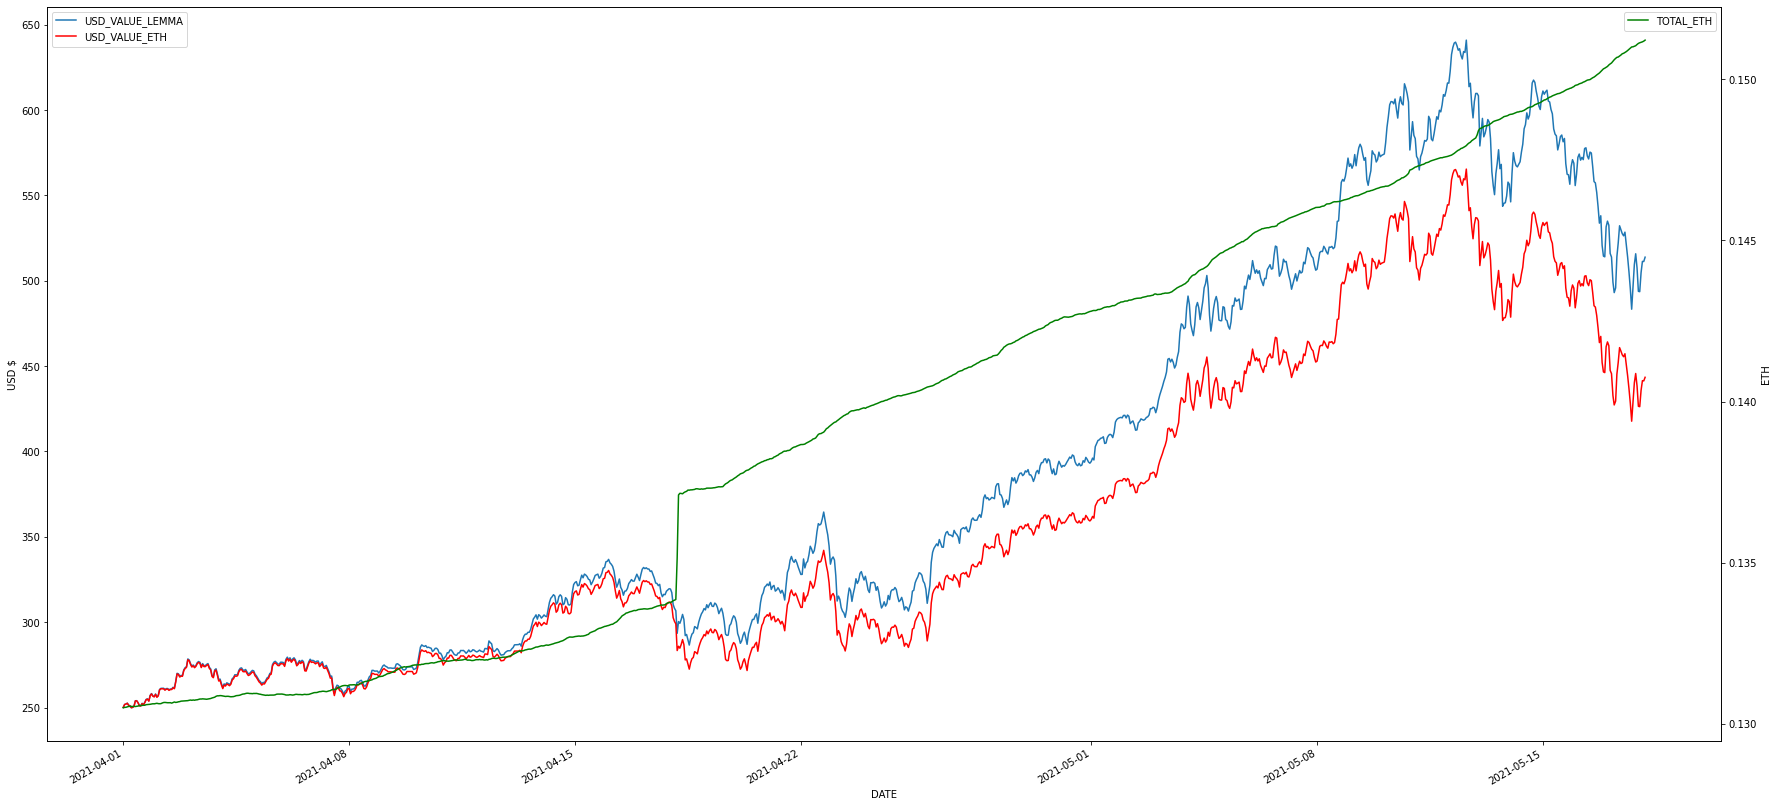

In [ ]:
# Figure Size Constant
figsize = (30, 15)

ax = statistics.plot('DATE', 'USD_VALUE_LEMMA', figsize = figsize)
statistics.plot('DATE', 'USD_VALUE_ETH', figsize = figsize, color = 'red', ax = ax)
ax.set_ylabel('USD $')
ax.ticklabel_format(style="plain", axis="y")
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
statistics.plot('DATE', 'TOTAL_ETH', figsize = figsize, color = 'green', ax = ax2)
ax2.set_ylabel('ETH')
ax2.legend(loc = 'upper right')

In [ ]:
asset_statistics = {
    "START ETH" : INITIAL_AMOUNT,
    "END ETH" : TOTAL_ETH,
    "ETH Gain" : ETH_GAIN,
    "ROI" : ROI_ETH * 100,
    "APY" : ((1 + ROI_ETH) ** (12/(abs(TIME_PERIOD.days)/30)) - 1) * 100,
    "TIME" : abs(TIME_PERIOD.days)

}
asset_statistics

{'APY': 201.81593188784873,
 'END ETH': 0.15120847491964126,
 'ETH Gain': 0.020708474919641257,
 'ROI': 15.868563156813224,
 'START ETH': 0.1305,
 'TIME': 48}

In [ ]:
# START ETH : The ETH balance we started off with
# END ETH : START ETH + All the gains we made
# ETH Gain : The ETH we made/lost
# ROI : The % returns in the given TIME period
# APY : Annualized ROI
# TIME : Current date - date of investment in days